In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import math
from glob import glob
import os
import random
import torch
import re
import datatable as dt
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
print("pd version : " + pd.__version__)
print("np version : " + np.__version__)

pd version : 1.1.5
np version : 1.19.5


In [3]:
class CFG:
    seed=42
    
root='/opt/ml/code/input/'
data_path=glob(root+'*.csv')
print(data_path)

['/opt/ml/code/input/sample_submission.csv', '/opt/ml/code/input/train.csv']


In [4]:
############SET SEED##############
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)
    
seed_everything(CFG.seed)

In [5]:
############LOAD DATA##############
sample_submission = pd.read_csv(data_path[0])
train = pd.read_csv(data_path[1])

In [6]:
############DATA SUMMARY##############
train.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   order_id     780502 non-null  object 
 1   product_id   780502 non-null  object 
 2   description  780502 non-null  object 
 3   quantity     780502 non-null  int64  
 4   order_date   780502 non-null  object 
 5   price        780502 non-null  float64
 6   customer_id  780502 non-null  int64  
 7   country      780502 non-null  object 
 8   total        780502 non-null  float64
dtypes: float64(2), int64(2), object(5)
memory usage: 53.6+ MB


In [8]:
len(train.customer_id.unique())

5914

In [9]:
print(train.order_date.min())
print(train.order_date.max())

2009-12-01 07:45:00
2011-11-30 17:42:00


In [10]:
train.isnull().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

In [11]:
train[train.customer_id==train.customer_id.min()]

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
21447,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,7.4250,12346,United Kingdom,74.2500
21702,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,7.4250,12346,United Kingdom,37.1250
21705,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,7.4250,12346,United Kingdom,37.1250
28492,492718,TEST001,This is a test product.,5,2009-12-18 10:47:00,7.4250,12346,United Kingdom,37.1250
28504,492722,TEST002,This is a test product.,1,2009-12-18 10:55:00,1.6500,12346,United Kingdom,1.6500
31276,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,7.4250,12346,United Kingdom,37.1250
31278,493412,TEST001,This is a test product.,5,2010-01-04 09:53:00,7.4250,12346,United Kingdom,37.1250
37892,494450,TEST001,This is a test product.,5,2010-01-14 13:50:00,7.4250,12346,United Kingdom,37.1250
44909,495295,TEST001,This is a test product.,5,2010-01-22 13:30:00,7.4250,12346,United Kingdom,37.1250
49055,C495800,ADJUST,Adjustment by john on 26/01/2010 17,-1,2010-01-26 17:27:00,170.7750,12346,United Kingdom,-170.7750


# 분석
1. object type인 컬럼 중 눈여겨 볼 것 : order_id, product_id
    - order_id : 맨 앞에 'C' 붙어있음
    - product_id : 5digit 외로 M,D,TEST,숫자 외 문자 첨가된 케이스들 존재 
2. 컬럼 간의 관계
    - order_id ~ order_date : 다른 product_id를 가져도 order_date가 같으면 order_id는 모두 동일하다.
3. 로그 생성 최소 단위
    - 분 단위
4. 결측치
    - 없음 

In [12]:
############데이터 가공##############
def make_time_series_data(train,criteria):
    # to_datetime
    standard=['customer_id',criteria]
    data=train[:]
    data[standard[1]]=pd.to_datetime(train.order_date).dt.strftime(standard[1])
    data.order_date=pd.to_datetime(data.order_date)

    # 월 단위로 틀을 만들고, 기준으로 aggregate해준 후 merge
    times=pd.date_range('2009-12-01',periods=(data.order_date.max()-data.order_date.min()).days+1,freq='1d') # x축
    date_frame=np.tile(times,len(data.customer_id.unique()))
    customer_id_frame=np.repeat(data.customer_id.unique(),len(times)) # array([13085, 13085, 13085, ..., 17911, 17911, 17911])

    frame=pd.DataFrame({'customer_id':customer_id_frame, 'order_date':date_frame})
    frame[standard[1]]=pd.to_datetime(frame.order_date).dt.strftime(standard[1])


    # groupby
    data_group=data.groupby(standard).sum().reset_index() # 월별로 num sum
    frame_group=frame.groupby(standard).count().reset_index().drop(['order_date'],axis=1) # standard 틀

    # merge
    merge=pd.merge(frame_group,data_group,on=standard,how='left').fillna(0)
    return merge

In [13]:
merge_temp=make_time_series_data(train,'%Y-%m')
merge_temp=merge_temp.rename(columns={'%Y-%m':'per_month'})
merge_temp.head()

,customer_id,per_month,quantity,price,total
0,12346,2009-12,26.0,31.3500,187.2750
1,12346,2010-01,19.0,200.4750,-22.2750
2,12346,2010-02,0.0,0.0000,0.0000
3,12346,2010-03,5.0,44.6325,44.6325
4,12346,2010-04,0.0,0.0000,0.0000


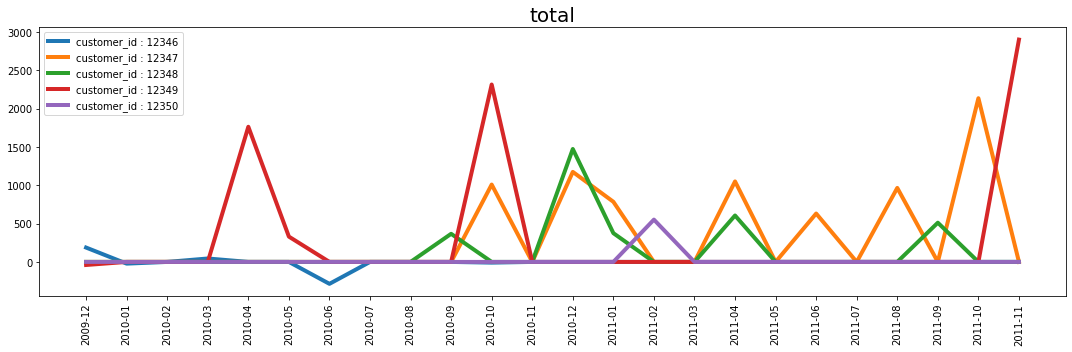

In [14]:
%matplotlib inline
plt.rcParams['figure.figsize']=(15,5)
plt.rcParams['lines.linewidth']=4

for customer_id in merge_temp.customer_id.unique()[:5]:
    temp=merge_temp[merge_temp.customer_id==customer_id][['per_month','total']]

    plt.plot(temp.per_month, temp.total, label="customer_id : " + str(customer_id))       
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("total", size=20)
    plt.tight_layout()

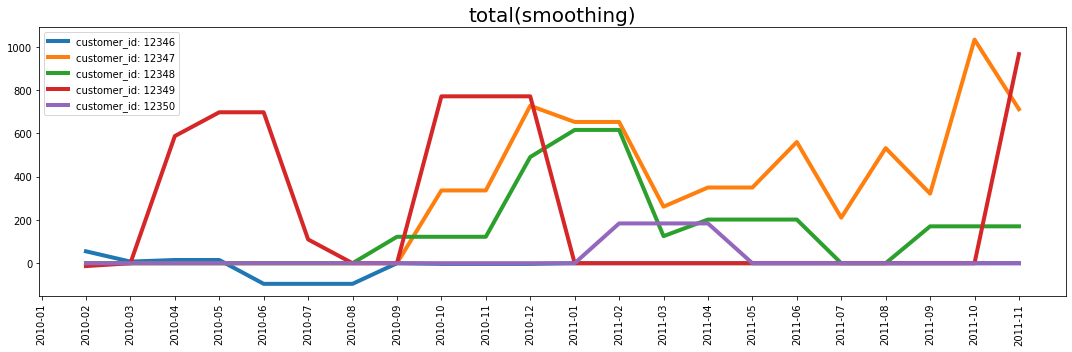

In [15]:
for customer_id in merge_temp.customer_id.unique()[0:5]:
    
    temp = merge_temp[merge_temp.customer_id == customer_id][["per_month",'total']]    
    plt.plot(temp.per_month, temp.total.rolling(window=3).mean(), label="customer_id: " + str(customer_id))
    plt.legend()
    plt.xticks(rotation=90)
    plt.title("total(smoothing)", size=20)
    plt.tight_layout()

구매기록이 거의 항상 0에 가까운 고객도 있고

꽤 주기적으로 구매하는 고객들도 있습니다.

또한, 조심해야할 부분이 2012년 12월 total 300 이상 혹은 미만 인데

앞선 기간 (예를 들면 2009년 12 ~ 2010년 12)에 많은 구매를 하고, 2011년도에는 구매 기록이 없는 경우 등,

이러한 부분들도 유심히 봐야할 것 같다는 생각이 듭니다.

혹은, 이 데이터 자체를 sequential한 데이터로 간주하고 다양한 방법들을 사용해 볼 수도 있을 것 같습니다

In [16]:
train.head()

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


In [17]:
len(train.order_id.unique())

43955

In [18]:
len(train.product_id.unique())

4645

In [19]:
len(train.description.unique())

5297

In [20]:
max(train.quantity)

74215

In [21]:
max(train.price)

64300.5

In [22]:
len(train.customer_id.unique())

5914

In [23]:
len(train.country.unique())

41

In [24]:
max(train.total)

127352.94

In [25]:
min(train.total)

-127352.94

In [26]:
!pip install sweetviz

In [28]:
import pandas as pd
import sweetviz as sv

advert_report = sv.analyze(train)
advert_report.show_html('./sweetviz_Advertising.html')


Report ./sweetviz_Advertising.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [205]:
# !jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [61]:
in_patterns=[]
out_patterns=[]

for p_id in train.product_id.unique():
    if p_id[:5].isdigit():
        in_patterns+=[p_id]
    else:
        out_patterns+=[p_id]

In [66]:
in_patterns[:5] # 물품의 색깔. 물품의 마이너한 디테일. 사이즈. L/S. 

['85048', '79323P', '79323W', '22041', '21232']

In [65]:
out_patterns2

['POST',
 'D',
 'M',
 'C2',
 'BANK CHARGES',
 'TEST001',
 'TEST002',
 'PADS',
 'ADJUST',
 'ADJUST2',
 'SP1002',
 'DOT',
 'CRUK']

In [68]:
len(in_patterns)

4632

In [69]:
##############